# Proyecciones locales dependientes del estado

- The Research Institute in Economics and Finance (RIEF) 
- Winter School Nonlinear Econometrics - Day 5


El código utiliza los datos trimestrales de la base macrodata de statsmodels (EE. UU. 1959‑2010). Calcula el **crecimiento del PIB real** (diferencia logarítmica), define un “shock” como el cambio en la **tasa de letras del Tesoro a 3 meses** y construye un indicador de estado que vale 1 si el crecimiento se encuentra por debajo de la mediana histórica (recesión) y 0 en caso contrario. Para cada horizonte de 1 a 8 trimestres se estima la regresión:

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.datasets import macrodata

In [17]:
# Cargar datos y crear índice temporal trimestral
data = macrodata.load_pandas().data
data['date'] = pd.period_range(start='1959Q1', periods=len(data), freq='Q')
data.set_index('date', inplace=True)

In [18]:
data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


In [19]:
# Crecimiento del PIB real (logaritmo y diferencia)
data['log_realgdp'] = np.log(data['realgdp'])
data['gdp_growth'] = data['log_realgdp'].diff() * 100

# Shock: cambio en la tasa de letras del Tesoro
data['shock'] = data['tbilrate'].diff()

In [20]:
# Eliminar filas con NA y definir estado: 1 si crecimiento < mediana (recesión)
df = data[['gdp_growth', 'shock']].dropna().copy()
threshold = df['gdp_growth'].median()
df['state'] = (df['gdp_growth'] < threshold).astype(int)

In [28]:
df['state'].head()

date
1959Q2    0
1959Q3    1
1959Q4    1
1960Q1    0
1960Q2    1
Freq: Q-DEC, Name: state, dtype: int32

In [21]:
print("Mediana del crecimiento del PIB real:",df['gdp_growth'].median())

Mediana del crecimiento del PIB real: 0.7652147240949425


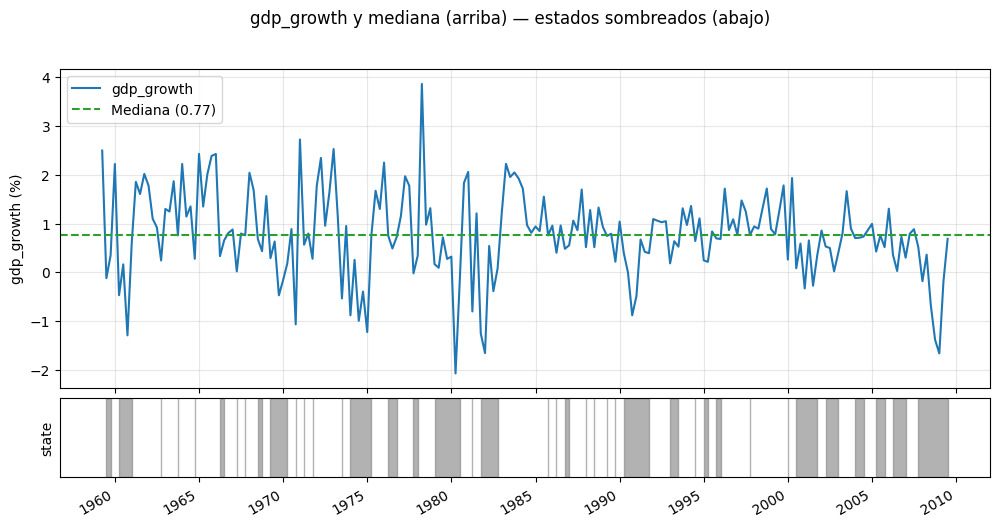

In [22]:
# Gráfico: panel superior = gdp_growth + mediana; panel inferior = state (sombreado)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

plot_df = df.copy()
if isinstance(plot_df.index, pd.PeriodIndex):
    plot_df.index = plot_df.index.to_timestamp()

median_value = plot_df['gdp_growth'].median()

fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# Panel superior: gdp_growth y mediana
ax0.plot(plot_df.index, plot_df['gdp_growth'], color='tab:blue', label='gdp_growth')
ax0.axhline(median_value, color='tab:green', linestyle='--', label=f'Mediana ({median_value:.2f})')
ax0.set_ylabel('gdp_growth (%)')
ax0.legend(loc='upper left')
ax0.grid(alpha=0.3)

# Panel inferior: state como bandas sombreadas
in_state = plot_df['state'] == 1
start = None
for i, val in enumerate(in_state):
    if val and start is None:
        start = plot_df.index[i]
    if not val and start is not None:
        end = plot_df.index[i-1]
        ax1.axvspan(start, end, color='gray', alpha=0.6)
        start = None
if start is not None:
    ax1.axvspan(start, plot_df.index[-1], color='gray', alpha=0.6)

ax1.set_ylim(0,1)
ax1.set_yticks([])
ax1.set_ylabel('state')

# Formato del eje x
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax0.get_xticklabels(), visible=False)
fig.autofmt_xdate()

plt.suptitle('gdp_growth y mediana (arriba) — estados sombreados (abajo)')
plt.show()

In [23]:
df

,gdp_growth,shock,state
date,,,
1959Q2,2.494213,0.26,0
1959Q3,-0.119295,0.74,1
1959Q4,0.349453,0.51,1
1960Q1,2.219018,-0.83,0
1960Q2,-0.468455,-0.82,1
...,...,...,...
2008Q3,-0.678136,-0.57,1
2008Q4,-1.380483,-1.05,1
2009Q1,-1.661198,0.10,1


### Variable and States

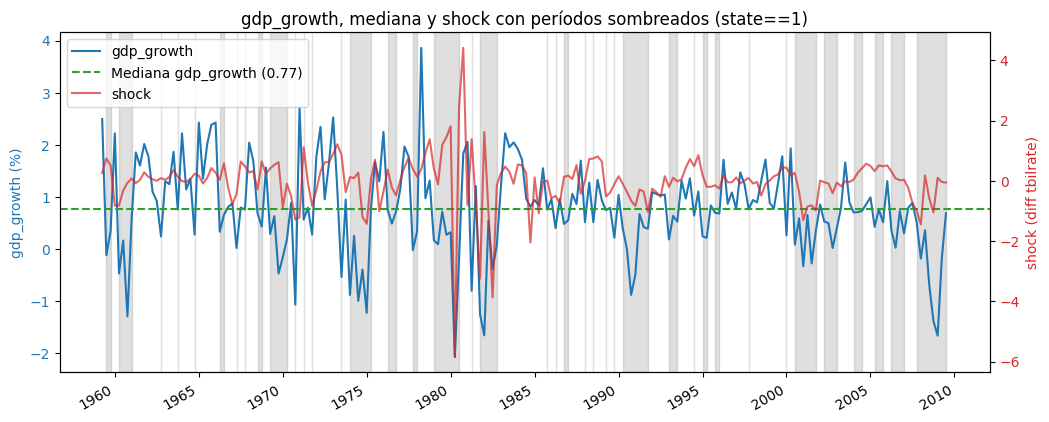

In [24]:
# Gráfica de gdp_growth, mediana y shock con sombreado para state==1
import matplotlib.dates as mdates

# Preparar datos para graficar
plot_df = df.copy()
if isinstance(plot_df.index, pd.PeriodIndex):
    plot_df = plot_df.copy()
    plot_df.index = plot_df.index.to_timestamp()

median_value = plot_df['gdp_growth'].median()

fig, ax1 = plt.subplots(figsize=(12,5))

# Línea de crecimiento del PIB
ax1.plot(plot_df.index, plot_df['gdp_growth'], label='gdp_growth', color='tab:blue')
# Línea de la mediana
ax1.axhline(median_value, color='tab:green', linestyle='--', label=f'Mediana gdp_growth ({median_value:.2f})')
ax1.set_ylabel('gdp_growth (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eje derecho para el shock (tasa de cambio)
ax2 = ax1.twinx()
ax2.plot(plot_df.index, plot_df['shock'], label='shock', color='tab:red', alpha=0.7)
ax2.set_ylabel('shock (diff tbilrate)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Mostrar state como sombreado por tramos continuos y como barras discretas en fondo
in_state = plot_df['state'] == 1
# Sombreado por tramos continuos
start = None
for i, val in enumerate(in_state):
    if val and start is None:
        start = plot_df.index[i]
    if not val and start is not None:
        end = plot_df.index[i-1]
        ax1.axvspan(start, end, color='gray', alpha=0.25)
        start = None
if start is not None:
    ax1.axvspan(start, plot_df.index[-1], color='gray', alpha=0.25)

# Además dibujar barras finas por trimestre para state (opcional)
state_bar_width = (plot_df.index[1] - plot_df.index[0]) * 0.8
ax1.bar(plot_df.index[in_state], [median_value*0.01]*in_state.sum(),
        width=state_bar_width, color='gray', alpha=0.0)  # invisible, sólo para referencia si se quiere reusar

# Formato del eje x
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Leyenda combinada
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('gdp_growth, mediana y shock con períodos sombreados (state==1)')
plt.show()

## Local Projection LP with state dependent variable

$$
Y_{t+h} = \alpha_h + \beta_h \, \text{shock}_t + \gamma_h \, (\text{shock}_t \times \text{estado}_t) + \sum_{p=1}^{P} \delta_{h,p} \, \text{shock}_{t-p} + \sum_{p=1}^{P} \phi_{h,p} \, \text{crec}_{t-p} + \varepsilon_{t+h}
$$

donde $Y_{t+h}$ es el crecimiento del PIB $h$ trimestres por delante y $crec_{t-p}$ son rezagos del crecimiento. La respuesta a un choque en un estado “bajo” (no recesión) es $\beta_h$, mientras que la respuesta en un estado “alto” (recesión) es $\beta_h + \gamma_h$.

Para robustez se utilizan errores estándar de Newey‑West (HAC).

In [25]:
# Settings inicial para el análisis
max_horizon = 8
lags = 4

# Listas para almacenar coeficientes e intervalos de confianza
coef_low, coef_high, se_low, se_high = [], [], [], []

In [26]:
# Estimación de regresiones para cada horizonte h
for h in range(1, max_horizon + 1):
    # Variable dependiente: crecimiento h pasos adelante (se adelanta usando shift negativo)
    Y = df['gdp_growth'].shift(-h)

    # Crear un DataFrame con la variable dependiente, el shock y el estado
    reg_df = pd.DataFrame({'Y': Y, 'shock': df['shock'], 'state': df['state']})

    # Crear interacción shock * estado para capturar diferencias por régimen
    reg_df['shock_state'] = reg_df['shock'] * reg_df['state']

    # Incorporar rezagos del shock y del crecimiento (control de dinámica)
    for p in range(1, lags + 1):
        reg_df[f'shock_lag{p}'] = df['shock'].shift(p)      # rezago p del shock
        reg_df[f'gdp_lag{p}'] = df['gdp_growth'].shift(p)    # rezago p del crecimiento

    # Eliminar observaciones con NA creados por los desplazamientos (lead/lags)
    reg_df = reg_df.dropna()

    # Definir la lista de regresores: shock, interacción y todos los rezagos
    X_cols = ['shock', 'shock_state'] + \
             [f'shock_lag{p}' for p in range(1, lags+1)] + \
             [f'gdp_lag{p}' for p in range(1, lags+1)]

    # Construir la matriz de diseño X e incluir una constante
    X = sm.add_constant(reg_df[X_cols])

    # Vector de la variable dependiente
    y = reg_df['Y']

    # Ajustar el modelo de mínimos cuadrados ordinarios con errores robustos HAC
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': h})

    # Extraer coeficientes de interés: efecto del shock en el estado bajo (β̂_shock)
    b_shock = model.params['shock']
    # y efecto adicional en el estado alto (γ̂)
    b_inter = model.params['shock_state']

    # Errores estándar de esos coeficientes
    se_shock = model.bse['shock']
    se_inter = model.bse['shock_state']

    # Covarianza entre los coeficientes para calcular la varianza del efecto combinado
    cov = model.cov_params().loc['shock', 'shock_state']

    # Impulso respuesta en estado bajo (no recesión): β̂_shock
    irf_low = b_shock
    # Impulso respuesta en estado alto (recesión): β̂_shock + γ̂
    irf_high = b_shock + b_inter

    # Errores estándar asociados a cada respuesta
    se_low_state = se_shock
    # Desviación estándar combinada para el efecto en recesión (propagación de varianzas)
    se_high_state = np.sqrt(se_shock**2 + se_inter**2 + 2 * cov)

    # Almacenar resultados en listas para graficar o analizar posteriormente
    coef_low.append(irf_low)
    coef_high.append(irf_high)
    se_low.append(se_low_state)
    se_high.append(se_high_state)


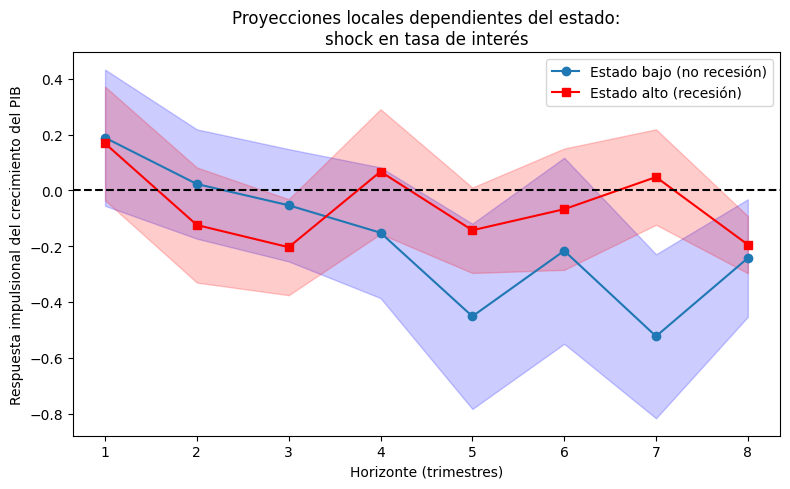

In [29]:
# Graficar las funciones de impulso respuesta dependientes del estado
horizons = np.arange(1, max_horizon+1)
plt.figure(figsize=(8, 5))
plt.plot(horizons, coef_low, marker='o', label='Estado bajo (no recesión)')
plt.fill_between(horizons, np.array(coef_low) - 1.96*np.array(se_low),
                 np.array(coef_low) + 1.96*np.array(se_low), color='blue', alpha=0.2)
plt.plot(horizons, coef_high, marker='s', color='red', label='Estado alto (recesión)')
plt.fill_between(horizons, np.array(coef_high) - 1.96*np.array(se_high),
                 np.array(coef_high) + 1.96*np.array(se_high), color='red', alpha=0.2)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Horizonte (trimestres)')
plt.ylabel('Respuesta impulsional del crecimiento del PIB')
plt.title('Proyecciones locales dependientes del estado:\nshock en tasa de interés')
plt.legend()
plt.tight_layout()
plt.show()

La gráfica muestra que la respuesta del crecimiento del PIB a un aumento inesperado en la tasa de interés es distinta durante recesiones (estado alto) y expansiones (estado bajo). 

El método puede adaptarse con otras variables (consumo, inflación, etc.) y con distintos criterios para definir el estado (por ejemplo, recesiones NBER, umbrales de inflación).